<a href="https://colab.research.google.com/github/ckotidis/BIAFinal-AnalysisOfPoseEstimation/blob/main/BIAanalysis_Corina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Corina Kotidis

Date: 5/16/2022

Project: Biomedical Image Analysis- Boston College

#DeepLabCut Model

Setting up DeepLabCut

In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [3]:
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import re
import matplotlib.pyplot as plt

['/content/drive/MyDrive/BIA_folder/videos/AD2205_Day2_Rat_1.MP4']

In [ ]:
#These are the terminal commands to run DeepLabCut
#Please refer to this paper for more details about each command
#https://www.nature.com/articles/s41596-019-0176-0

projectName = 'BIAFinal2022'
experimenters = 'Corina Kotidis and Jennifer Joseph'

path = '/content/drive/MyDrive/BIA_folder/videos/'
videoPath_list = []
for filename in os.listdir(path):
  videoPath_list.append(path+filename)

! import deeplabcut as dlc

! cp = dlc.create_new_project(projectName,experimenters,videoPath_list, copy_videos=False,videotype='mp4')

! dlc.extract_frames(cp, 'automatic', 'uniform',crop=True, userfeedback=False)

! dlc.label_frames(cp)

! dlc.check_labels(cp)

! dlc.create_training_data(cp)

! dlc.train_network(cp, gputouse=1, max_snapshots_to_keep=0, autotune=False, displayiters=0, maxiters=50000)

! dlc.evaluate_newtwork(cp, plotting=True)

! dlc.analyze_videos(cp, videoPath_list, save_as_csv=True, videotype = '.avi')

! dlc.plot_trajectories(cp,videoPath_list)

! dlc. create_labeled_video(cp, videoPath_list)

! dlc.refine_labels(cp)

#Pre-processing

In [ ]:
############################################################################################################
#BEFORE RUNNING: Must compile a text file with all the delays (in the format "(day)rat (ratnumber):(delay)") 
############################################################################################################
#Converts text file into an array where the days are the rows and the columns are the rats 
#The value at each position is the delay for that day (row) and rat (col)

#Creates array
reference = np.zeros((6,17))
#Accesses the text file
with open('/content/drive/MyDrive/BIA_folder/preproctimes.txt') as time_file:
    for line in time_file:
      #Finds all the numbers in the string
      nums = re.findall(r'\d+', line)

      #Obtains the dealy
      time = re.findall(r'\d+',re.findall(r'\d+-',line)[0])[0] 

      #Upates the delay in the numpy array
      reference[int(nums[0]), int(nums[1])]=int(time)

#Day 4, Rat 16 was not in the textfile so I just augmented it here
reference[4,16]='08'

In [ ]:
#Processes and converts the CSV files into a list

#Get video CSVs into list
framespersecond=30
csv_list = []
right_left = []

#Iterating through the list of CSVs
for file_name in tqdm(os.listdir('/content/drive/MyDrive/BIA_folder/csvs/')):
  #Ensuring that we are only using CSV files
  if file_name.endswith('.csv'): 
    #Convert CSV file to DataFrame
    csv = pd.read_csv('/content/drive/MyDrive/BIA_folder/csvs/'+file_name, dtype='a')
    
    #Determine delay from reference array with delays
    numbers = re.findall(r'\d+', file_name) #Finds all the numbers in the file name
    start_time = int(reference[int(numbers[1]),int(numbers[2])]) #Gets delay from reference array
    
    #Remove rows in CSV file that are not necessary
    csv.drop(csv.index[2:start_time*framespersecond],axis=0, inplace=True) 
    csv.drop(csv.index[start_time*framespersecond+1:start_time*framespersecond+9001],axis=0, inplace=True)
    
    #Converts csv to numpy 
    numpy_csv = csv.to_numpy()
    for row in range(2,numpy_csv.shape[0]):
      for col in range(1,numpy_csv.shape[1]):
        #Converts each value to a float
        numpy_csv[row,col] = float(numpy_csv[row,col])

    #Collects processed CSV files into list
    csv_list.append(numpy_csv)
    
    #Keeps track of left and right sided videos
    if '(1)' in file_name:
      right_left.append('R')
    else: 
      right_left.append('L')

100%|██████████| 129/129 [00:15<00:00,  8.26it/s]


#Error Rate

In [ ]:
def error_rate(csv_List):
#Calculates the sum of the liklihoods per bodypart
#Returns dataframe of the error rate at each body part

  #Creates dataframe to keep track of running sum
  errordf = pd.DataFrame({'nose':[0],'L eye':[0],'R eye':[0], 'L ear':[0],'R ear':[0],'tail base':[0]})

  #Iterates through the list of CSV files
  for index, csv in enumerate(csv_List):

    #Collects the liklihoods for each bodypart
    #Order: nose, L eye, R eye, L ear, R ear, tail base
    likelihoods = csv[:, [3,6,9,12,15,18]]

    #Iterates through the liklihoods for the bodyparts at each frame
    for ind, bodypart in enumerate(likelihoods[0]):
      #Calculates the sum
      sum = np.sum(likelihoods[2:,ind])
      #Adds it the sum to the running sum in the dataframe
      errordf.loc[0,bodypart]+= sum

  #Calculates total number of instances
  total = likelihoods.shape[0]*len(csv_list)
  #Divide running sum by total
  return errordf/total

display(error_rate(csv_list))

,nose,L eye,R eye,L ear,R ear,tail base
0,0.808774,0.762725,0.786765,0.95734,0.951195,0.71183


#Head Direction

Accessory Methods

In [ ]:
def calc_slope(X1, Y1, X2, Y2):
#Returns the slope (s) and B in the equation y=sx+B
#(X1, Y1) are a point pair, (X2, Y2) are a point pair
  s = (Y1-Y2)/(X1-X2)
  B = Y1-(s*X1)
  return s, B

def assessmentRight(Y_nose, Y_referenceL, Y_referenceR, X_nose, X_referenceL, X_referenceR):
#Determines whether the head direction is facing towards target rat, signifying a potential for interaction
#This is for videos that have been cropped so that only the right-side of the arena is visible. 
#Therefore, an interaction would be when the rat's head is in the direction of the left of the screen
#True means a positive head direction (i.e. looking for an interaction)
#False means a negative head direction (i.e. not looking for an interaction) 
  result = False
  
#Checks to see if rat is facing upwards in the videos
#0 is on top right corner
  #if y coordinate for the nose is higher on the screen than the y coordinate of the left reference body part
  if Y_nose < Y_referenceL:
    #if the x coordinate for the nose is more to the left than the x coordinate of the right reference body part 
    if X_nose > X_referenceL: 
      result = True
    else: 
      result = False

#Checks to see if rat is facing downwards in the videos
#0 is on top right corner
  #if y coordinate for the nose is lower on the screen than the y coordinate of the right reference body part
  elif Y_nose > Y_referenceR: 
    #if the x coordinate for the nose is more to the left than the x coordinate of the right reference body part 
    if X_nose > X_referenceR: 
      result = True
    else: 
      result = False

#If its not facing upwards or downwards, they must be parallel (this would only happen if there was a mistake in the pose estimation)
#0 is on top right corner
  else:
    #if the x coordinate for the nose is more to the left than the x coordinate of the right or left reference body part 
    if X_nose > X_referenceL or X_nose > X_referenceR:
      result= True
    else:
      result = False

  return result

def assessmentLeft(Y_nose, Y_referenceL, Y_referenceR, X_nose, X_referenceL, X_referenceR):
#Determines whether the head direction is facing towards target rat, signifying a potential for interaction
#This is for videos that have been cropped so that only the left-side of the arena is visible. 
#Therefore, an interaction would be when the rat's head is in the direction of the right of the screen
#True means a positive head direction (i.e. looking for an interaction)
#False means a negative head direction (i.e. not looking for an interaction) 
  
  result = False
#Checks to see if rat is facing upwards in the videos
#0 is on top right corner
  #if y coordinate for the nose is higher on the screen than the y coordinate of the right reference body part
  if Y_nose < Y_referenceR:
    #if the x coordinate for the nose is more to the right than the x coordinate of the right reference body part 
    if X_nose < X_referenceR: 
      result = True
    else: 
      result = False

#Checks to see if rat is facing downwards in the videos
#0 is on top right corner
  #if y coordinate for the nose is lower on the screen than the y coordinate of the left reference body part
  elif Y_nose > Y_referenceL:
    #if the x coordinate for the nose is more to the left than the x coordinate of the left reference body part 
    if X_nose < X_referenceL: #0 is on right side
      result = True
    else: 
      result = False

#If its not facing upwards or downwards, they must be parallel (this would only happen if there was a mistake in the pose estimation)
#0 is on top right corner
  else:
    #if the x coordinate for the nose is more to the left than the x coordinate of the right or left reference body part 
    if X_nose < X_referenceL or X_nose < X_referenceR:
      result= True
    else:
      result = False

  return result

def show_result(masterlist):
#Converts the master list created by the run function to a plot
  results =[]
  
  #Iterates through master list
  for csv in masterlist: 
    #Determines total number of CSVs (note: minus two so that the headers are not included)
    total = len(csv)-2
    
    #Determine number of frames with positive head direction 
    positive = sum(csv)

    #Appends percentage to list
    results.append(positive/total)

  #Plots the percentages by the CSV number in the list 
  plt.plot(range(len(masterlist)), results)
  plt.ylabel('Percent of Positive Head Direction')
  plt.xlabel('CSV file')
  plt.title('Potential Interactions Per CSV File')
  plt.show()

Main Method

In [ ]:
def run(csv_List,side_List):
#This method iterates through the list of CSV files and returns a final list of 
#the frames with positive (True) head direction and negative (False) head direction. 

  #Variable so that accessing the respective values is more clear
  nose = 0
  Leye = 1
  Reye = 2
  Lear = 3
  Rear = 4

  #Threshold for liklihoods
  threshold = .75

  #This will be the final list for all the CSVs
  master_direction=[]

  #Iterates through each CSV files in the list of CSV files
  for ind, csv in enumerate(csv_List):
    #Creates separate lists for the likelihood, x-coordinates, and y-coordinates for each body part in the CSV file
    #order: nose, L eye, R eye, L ear, R ear
    likelihoods = csv[:, [3,6,9,12,15]]
    Xcoords = csv[:,[1,4,7,10,13]]
    Ycoords = csv[:,[2,4,8,11,14]]
  
    #Initializes the list for each CSV file
    direction=[]
    #Sets the first two instances to False, so that the index in the CSV will match up with the index in this list
    direction.append(False)
    direction.append(False)
    
    #Determines if the video is a right-sided video
    if side_List[ind]=='R': #RIGHT    
      
      #Iterates through each frame of the CSV file (note: the first two rows in each file are headers)
      for frame in range(2,len(csv)):
        
        #Determines if the likelihoods are high enough for the nose and eyes. 
        if float(likelihoods[frame][nose]) >threshold and float(likelihoods[frame][Leye])>threshold and float(likelihoods[frame][Reye])>threshold: 
          #Uses the nose and the eyes to determine positive or negative head direction
          direction.append(assessmentRight(Ycoords[frame][nose],Ycoords[frame][Leye], Ycoords[frame][Reye], Xcoords[frame][nose],Xcoords[frame][Leye],Xcoords[frame][Reye]))

        #If the likelihood of the eyes are not high enough, determines if the likelihoods are high enough for the nose and ears. 
        elif float(likelihoods[frame][nose]) >threshold and float(likelihoods[frame][Lear])>threshold and float(likelihoods[frame][Rear])>threshold: #Can use nose and eyes
          #Uses the nose and ears to determine positive or negative head direction
          direction.append(assessmentRight(Ycoords[frame][nose],Ycoords[frame][Lear], Ycoords[frame][Rear], Xcoords[frame][nose],Xcoords[frame][Lear],Xcoords[frame][Rear]))

        #If the likelihoods of the nose is not high enough, determine if the likelihoods are high enough for the eyes and ears
        elif float(likelihoods[frame][nose])<threshold and float(likelihoods[frame][Leye])>threshold and float(likelihoods[frame][Reye])>threshold and float(likelihoods[frame][Lear])>threshold and float(likelihoods[frame][Rear])>threshold: 
          #Calculate the slope for the lines that pass through the left ear and left eye
          # 1-eyes, 2-ear
          x1L= Xcoords[frame][Leye]
          y1L= Ycoords[frame][Leye]
          x2L= Xcoords[frame][Lear]
          y2L= Ycoords[frame][Lear]
          slopeL, bL = calc_slope(x1L,y1L,x2L,y2L)

          #Calculate the slope for the lines that pass through the right ear and right eye
          #1-eyes, 2-ears
          x1R= Xcoords[frame][Reye]
          y1R= Ycoords[frame][Reye]
          x2R= Xcoords[frame][Rear]
          y2R= Ycoords[frame][Rear]
          slopeR, bR = calc_slope(x1R,y1R,x2R,y2R)

          #Determines the nose to be at the intersection of the lines
          predictedNose_x = (bR-bL)/(slopeL-slopeR)
          predictedNose_y = slopeL*predictedNose_x+bL

          #Uses the predicted nose and eyes to determine positive or negative head direction
          direction.append(assessmentRight(predictedNose_y,Ycoords[frame][Leye], Ycoords[frame][Reye], predictedNose_x,Xcoords[frame][Leye],Xcoords[frame][Reye]))

        #Determines if the ears are the only body part with high liklihood
        elif float(likelihoods[frame][Lear])>threshold and float(likelihoods[frame][Rear])>threshold: 
          #Predicts direction of nose
          #Determines highest likelihood of the nose within window, saves index
          if frame+2<len(likelihoods)-1 and frame-2>4:
            for frame_ind in range(frame-2,frame+2):
              estimate = 0
              save_ind = 0
              if float(likelihoods[frame_ind][nose])> estimate:
                estimate = likelihoods[frame_ind][nose]
                save_ind = frame_ind
          
          #Case: frame is too close to the end to use full window
          elif frame+2>len(likelihoods): 
            for frame_ind in range(frame-2, frame):
              estimate = 0
              save_ind = 0
              if float(likelihoods[frame_ind][nose])> estimate:
                estimate = likelihoods[frame_ind][nose]
                save_ind = frame_ind
          #Case: frame is too close to the beginning to use full window
          elif frame-2<4:
            for frame_ind in range(frame, frame+2):
              estimate = 0
              save_ind = 0
              if float(likelihoods[frame_ind][nose])> estimate:
                estimate = likelihoods[frame_ind][nose]
                save_ind = frame_ind

          #Uses the highest estimated nose position and ears to determine positive or negative head direction 
          direction.append(assessmentRight(Ycoords[save_ind][nose],Ycoords[frame][Lear], Ycoords[frame][Rear], Xcoords[save_ind][nose],Xcoords[frame][Lear],Xcoords[frame][Rear]))
      
      #Append list of positive or negative head directions for each CSV file to the master list
      master_direction.append(direction)
    
    #Determines if the video is a right-sided video
    elif right_left[ind]=='L': #LEFT
      #Iterates through each frame of the CSV file (note: the first two rows in each file are headers)
      for frame in range(2,len(csv)):
        
        #Determines if the likelihoods are high enough for the nose and eyes. 
        if float(likelihoods[frame][nose]) >threshold and float(likelihoods[frame][Leye])>threshold and float(likelihoods[frame][Reye])>threshold: 
          #Uses the nose and the eyes to determine positive or negative head direction
          direction.append(assessmentLeft(Ycoords[frame][nose],Ycoords[frame][Leye], Ycoords[frame][Reye], Xcoords[frame][nose],Xcoords[frame][Leye],Xcoords[frame][Reye]))

        #If the likelihood of the eyes are not high enough, determines if the likelihoods are high enough for the nose and ears. 
        elif float(likelihoods[frame][nose]) >threshold and float(likelihoods[frame][Lear])>threshold and float(likelihoods[frame][Rear])>threshold: #Can use nose and eyes
          #Uses the nose and the ears to determine positive or negative head direction
          direction.append(assessmentLeft(Ycoords[frame][nose],Ycoords[frame][Lear], Ycoords[frame][Rear], Xcoords[frame][nose],Xcoords[frame][Lear],Xcoords[frame][Rear]))

        #If the likelihoods of the nose is not high enough, determine if the likelihoods are high enough for the eyes and ears
        elif float(likelihoods[frame][nose]) <threshold and float(likelihoods[frame][Leye])>threshold and float(likelihoods[frame][Reye])>threshold and float(likelihoods[frame][Lear])>threshold and float(likelihoods[frame][Rear])>threshold: 
          #Calculate the slope for the lines that pass through the left ear and left eye
          # 1-eyes, 2-ear
          x1L= Xcoords[frame][Leye]
          y1L= Ycoords[frame][Leye]
          x2L= Xcoords[frame][Lear]
          y2L= Ycoords[frame][Lear]
          slopeL, bL = calc_slope(x1L,y1L,x2L,y2L)

          #Calculate the slope for the lines that pass through the right ear and right eye
          #1-eyes, 2-ears
          x1R= Xcoords[frame][Reye]
          y1R= Ycoords[frame][Reye]
          x2R= Xcoords[frame][Rear]
          y2R= Ycoords[frame][Rear]
          slopeR, bR = calc_slope(x1R,y1R,x2R,y2R)

          #Determines the nose to be at the intersection of the lines
          predictedNose_x = (bR-bL)/(slopeL-slopeR)
          predictedNose_y = slopeL*predictedNose_x+bL
          
          #Uses the predicted nose and eyes to determine positive or negative head direction
          direction.append(assessmentLeft(predictedNose_y,Ycoords[frame][Leye], Ycoords[frame][Reye], predictedNose_x,Xcoords[frame][Leye],Xcoords[frame][Reye]))

        #Determines if the ears are the only body part with high liklihood
        elif float(likelihoods[frame][Lear])>threshold and float(likelihoods[frame][Rear])>threshold: 
          #Predicts direction of nose
          #Determines highest likelihood of the nose within window, saves index
          if frame+2<len(likelihoods)-1 and frame-2>4:
            for frame_ind in range(frame-2,frame+2):
              estimate = 0
              save_ind = 0
              if float(likelihoods[frame_ind][nose])> estimate:
                estimate = likelihoods[frame_ind][nose]
                save_ind = frame_ind
            #Uses the highest estimated nose position and ears to determine positive or negative head direction 
            direction.append(assessmentLeft(Ycoords[save_ind][nose],Ycoords[frame][Lear], Ycoords[frame][Rear], Xcoords[save_ind][nose],Xcoords[frame][Lear],Xcoords[frame][Rear]))

          #Case: frame is too close to the end to use full window
          elif frame+2>len(likelihoods): 
            for frame_ind in range(frame-2, frame):
              estimate = 0
              save_ind = 0
              if float(likelihoods[frame_ind][nose])> estimate:
                estimate = likelihoods[frame_ind][nose]
                save_ind = frame_ind
            #Uses the highest estimated nose position and ears to determine positive or negative head direction 
            direction.append(assessmentLeft(Ycoords[save_ind][nose],Ycoords[frame][Lear], Ycoords[frame][Rear], Xcoords[save_ind][nose],Xcoords[frame][Lear],Xcoords[frame][Rear]))

          #Case: frame is too close to the beginning to use full window
          elif frame-2<4:
            for frame_ind in range(frame, frame+2):
              estimate = 0
              save_ind = 0
              if float(likelihoods[frame_ind][nose])> estimate:
                estimate = likelihoods[frame_ind][nose]
                save_ind = frame_ind
            #Uses the highest estimated nose position and ears to determine positive or negative head direction 
            direction.append(assessmentLeft(Ycoords[save_ind][nose],Ycoords[frame][Lear], Ycoords[frame][Rear], Xcoords[save_ind][nose],Xcoords[frame][Lear],Xcoords[frame][Rear]))
     
      #Append list of positive or negative head directions for each CSV file to the master list
      master_direction.append(direction)

  return master_direction

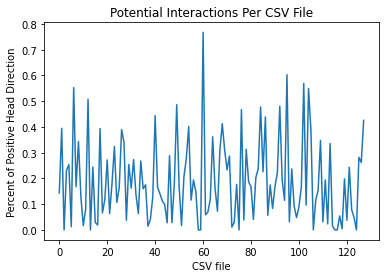

In [ ]:
show_result(run(csv_list, right_left))